<a href="https://colab.research.google.com/github/kerryqliu/stats170/blob/david/tfidfnaivebayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import nltk
import re
from sqlalchemy import create_engine
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
query2 = "SELECT * from completeDocs f join documentLabels d on f.docid = d.docid;"
fulldocs = pd.read_sql_query(query2, con=engine)
fulldocs

,docid,completetext,docid,caseid,label
0,1.0,Example 1\nReferring Doctor: Unknown Provider\...,1,-1,1.0
1,2.0,Example 2\nProgress Notes\nDate:\nPatient:\nDa...,2,-1,1.0
2,3.0,Example 3\nChief Complaint:\n1. Rapidly progre...,3,-1,4.0
3,4.0,14.0 mm MALIA.\nLAVA\nPELSING U/LNWAL900-#-WEL...,4,11594,1.0
4,5.0,The first set of documents behind this cover p...,5,11594,1.0
...,...,...,...,...,...
140,143.0,Fax Server\nFAX - CONFIDENTIAL\nTo:\nCompany;\...,143,207261,2.0
141,144.0,FAX COVER SHEET\nTO:\nDEPT:\nd\nFAX:\nFROM\nDA...,144,207365,2.0
142,145.0,FAX COVER SHEET\nDATE:\nTO;\nPHONE NUMBER:\nFA...,145,207766,2.0
143,146.0,Page 1/20\nPatient Profile\nResp Provider:\nPa...,146,207813,2.0


In [21]:
corpus = []
tags = []
for i, row in fulldocs.iterrows():
  corpus.append(row['completetext'])
  tags.append(row['label'])

TF-IDF w/ Naive Bayes (Vocabulary from Sentences)

In [62]:
testQuery = "SELECT * from docSentences d join sentenceLabels l on d.docid = l.docid and d.sentencenum = l.sentencenum;"
docs = pd.read_sql_query(testQuery, con=engine)
reflex_df = docs[docs["label"] !=0]
reflex_words = set()
for i, row in reflex_df.iterrows():
  for j in row['sentence'].split():
    reflex_words.add(j)

In [63]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from time import time
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [64]:
test_accuracy = []
test_f1 = []
train_accuracy = []
train_f1 = []
y_test_all = []
y_pred_all = []
conf_matrix_list_of_arrays = []
X = np.array(corpus)
y = np.array(tags)
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,2), vocabulary = reflex_words)
skf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
for train_index, test_index in skf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)
  selector = SelectPercentile(f_classif, percentile=10)
  selector.fit(X_train, y_train)
  X_train = selector.transform(X_train).toarray()
  X_test = selector.transform(X_test).toarray()
  model = GaussianNB()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  test_accuracy.append(accuracy_score(y_test, y_pred))
  test_f1.append(f1_score(y_test, y_pred, average='weighted'))
  conf_matrix = confusion_matrix(y_test, y_pred)
  conf_matrix_list_of_arrays.append(conf_matrix)
  #print(confusion_matrix(y_test, y_pred))
  y_pred = model.predict(X_train)
  train_accuracy.append(accuracy_score(y_train, y_pred))
  train_f1.append(f1_score(y_train, y_pred, average='weighted'))
  #scores = cross_val_score(model, X_test, y_test, cv=skf, scoring="f1_micro")

print("Mean test accuracy: ", np.mean(test_accuracy))
print("Mean test F1: ", np.mean(test_f1))
print("Mean train accuracy: ", np.mean(train_accuracy))
print("Mean train F1: ", np.mean(train_f1))
print(conf_matrix_list_of_arrays)
sum_of_conf_matrix_arrays = np.sum(conf_matrix_list_of_arrays, axis=0)
print(sum_of_conf_matrix_arrays)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr

Mean test accuracy:  0.45517241379310347
Mean test F1:  0.38437357762221647
Mean train accuracy:  0.9896551724137931
Mean train F1:  0.9897796179388264
[array([[ 1,  3,  0,  0,  0],
       [ 0, 12,  0,  2,  0],
       [ 0,  4,  0,  0,  0],
       [ 0,  3,  0,  0,  0],
       [ 0,  2,  0,  1,  1]]), array([[ 0,  1,  0,  2,  1],
       [ 0, 12,  0,  2,  0],
       [ 0,  2,  1,  1,  0],
       [ 0,  2,  0,  1,  0],
       [ 0,  4,  0,  0,  0]]), array([[ 0,  4,  0,  0,  1],
       [ 0, 10,  1,  2,  1],
       [ 0,  4,  0,  0,  0],
       [ 0,  3,  0,  0,  0],
       [ 1,  1,  0,  0,  1]]), array([[ 0,  2,  0,  2,  0],
       [ 0, 13,  0,  1,  0],
       [ 0,  2,  1,  0,  1],
       [ 0,  3,  0,  0,  1],
       [ 0,  1,  0,  0,  2]]), array([[ 0,  2,  2,  0,  0],
       [ 0, 10,  1,  1,  2],
       [ 0,  3,  0,  0,  1],
       [ 0,  3,  0,  1,  0],
       [ 0,  3,  0,  0,  0]])]
[[ 1 12  2  4  2]
 [ 0 57  2  8  3]
 [ 0 15  2  1  2]
 [ 0 14  0  2  1]
 [ 1 11  0  1  4]]


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4')]

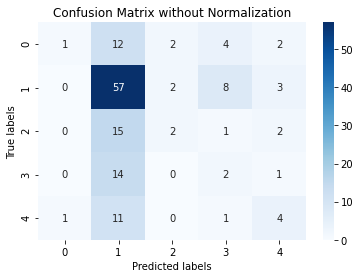

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(sum_of_conf_matrix_arrays, annot=True, fmt='g', ax=ax, cmap="Blues")  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix without Normalization')
ax.xaxis.set_ticklabels(["0","1","2","3","4"]); ax.yaxis.set_ticklabels(["0","1","2","3","4"])



[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4')]

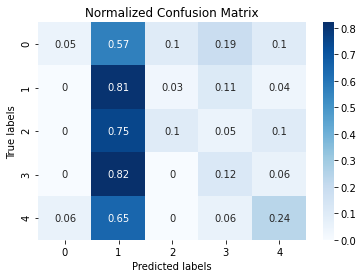

In [66]:
sum_of_rows = sum_of_conf_matrix_arrays.sum(axis=1)
normalized_array = sum_of_conf_matrix_arrays / sum_of_rows[:, np.newaxis]
normalized_array = np.round(normalized_array,2)
ax= plt.subplot()
sns.heatmap(normalized_array, annot=True, fmt='g', ax=ax, cmap="Blues")  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(["0","1","2","3","4"]); ax.yaxis.set_ticklabels(["0","1","2","3","4"])

TF-IDF W/ Naive Bayes (Vocabulary from Important Words file)

In [67]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from time import time
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
f = open("/content/drive/Shareddrives/CAPSTONE/Resources/important_words.txt", "r")
data = f.read()
print(data.split('\n'))
words = data.split('\n')
words = list(set(words))

['0', '1', '2', '3', '4', '5', '1+', '2+', '3+', '4+', '2-', '3-', '4-', '+4', '+3', '+2', '+1', '1-', '1/1', '1/2', '1/3', '1/4', '1/5', '2/1', '2/2', '2/3', '2/4', '2/5', '3/1', '3/2', '3/3', '3/4', '3/5', '4/1', '4/2', '4/3', '4/4', '4/5', '5/1', '5/2', '5/3', '5/4', '5/5', 'abnormal', 'abnormalities', 'absent', 'achilles', 'adductor', 'alert', 'amplitude', 'ankle', 'ankles', 'anterior', 'asymmetric', 'asymmetric', 'ataxic', 'ataxla', 'autonomic', 'babinski', 'babinskis', "babinski's", 'biceps', 'bilateral', 'B/L', 'bilaterally', 'br', 'br', 'brachioradialis', 'radialis', 'brisk', 'calves', 'carpal', 'cervical', 'chronic', 'cidp', 'cidp', 'conduction', 'conduction', 'cuff', 'decrease', 'decreased', 'deficit', 'delayed', 'deltoid', 'deltoids', 'depressed', 'depressed', 'dexterity', 'diffuse', 'diminished', 'discontinue', 'disease', 'distal', 'dorsal', 'dorsiflexion', 'downgoing', 'down', 'dull', 'dysesthesia', 'elevated', 'enhanced', 'extremities', 'extremity', 'fasciculation', 'fasc

In [80]:
vectorizer = TfidfVectorizer(analyzer='word')
test_docs = vectorizer.fit_transform(corpus)
vocabulary = vectorizer.get_feature_names()
final_vocab = []

# get overlapping words with relevant words and word vectors made from the document
for vocab in vocabulary:
  splits = vocab.split()
  for w in words:
    if w in splits:
      final_vocab.append(vocab)
      break


In [81]:
vectorizer = TfidfVectorizer(analyzer='word', vocabulary=final_vocab)
test_docs = vectorizer.fit_transform(corpus)
vocabulary = vectorizer.get_feature_names()

In [82]:
vocabulary = vectorizer.get_feature_names()
test = pd.DataFrame(data=test_docs.toarray(), columns=vocabulary)
test

,abnormal,abnormalities,absent,achilles,adductor,alert,amplitude,ankle,ankles,anterior,asymmetric,ataxic,ataxla,autonomic,babinski,biceps,bilateral,bilaterally,br,brachioradialis,brisk,calves,carpal,cervical,chronic,cidp,clonus,conduction,cuff,decrease,decreased,deficit,delayed,deltoid,deltoids,depressed,dexterity,diffuse,diminished,discontinue,...,reinnervation,response,responses,responsive,right,rotator,sensitive,sensorimotor,severe,shoulder,slow,sore,spondylosis,spread,stenosis,strength,symmetric,symmetrical,tarsal,tendon,thigh,through,throughout,thumbs,tibial,tibialis,tinel,toe,toes,tone,trace,tricep,triceps,tricepts,tunnel,ulnar,unsteadiness,upper,worse,wrist
0,0.000000,0.000000,0.061754,0.000000,0.0,0.063131,0.000000,0.059123,0.095419,0.161342,0.000000,0.00000,0.0,0.0,0.000000,0.067542,0.000000,0.058700,0.0,0.00000,0.0,0.000000,0.000000,0.072448,0.000000,0.000000,0.0,0.000000,0.133211,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.176979,0.099499,0.000000,0.0,...,0.000000,0.000000,0.082085,0.0,0.189060,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.165186,0.154646,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.066523,0.087427,0.0,0.255173,0.000000,0.144896,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.058378,0.000000,0.089502,0.000000,0.0,0.030499,0.099404,0.000000,0.046098,0.000000,0.000000,0.00000,0.0,0.0,0.062236,0.032630,0.090160,0.056717,0.0,0.00000,0.0,0.000000,0.000000,0.035000,0.027955,0.121101,0.0,0.000000,0.000000,0.0,0.091498,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.052665,0.0,...,0.000000,0.067828,0.000000,0.0,0.182673,0.0,0.0,0.000000,0.033914,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.266010,0.037356,0.0,0.0,0.000000,0.059409,0.000000,0.000000,0.0,0.064276,0.000000,0.0,0.123276,0.114933,0.070001,0.000000,0.0,0.000000,0.112028,0.000000,0.000000,0.0,0.173870,0.000000,0.000000
2,0.151629,0.000000,0.000000,0.054778,0.0,0.026406,0.000000,0.000000,0.000000,0.033742,0.180157,0.00000,0.0,0.0,0.000000,0.084753,0.234179,0.024552,0.0,0.04207,0.0,0.064143,0.000000,0.000000,0.096813,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.07452,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.034334,0.0,0.514008,0.0,0.0,0.041176,0.088087,0.000000,0.032074,0.000000,0.128286,0.0,0.084140,0.000000,0.032342,0.0,0.0,0.000000,0.000000,0.094689,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.030303,0.000000,0.0,0.088087,0.000000,0.000000,0.000000,0.0,0.150534,0.000000,0.024908
3,0.026633,0.000000,0.136108,0.000000,0.0,0.027829,0.120933,0.104248,0.042061,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.082265,0.025875,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.025507,0.110497,0.0,0.125731,0.058720,0.0,0.000000,0.066053,0.103862,0.00000,0.0,0.0,0.000000,0.087720,0.048054,0.0,...,0.000000,0.000000,0.108550,0.0,0.125008,0.0,0.0,0.043394,0.154722,0.036503,0.067605,0.000000,0.000000,0.0,0.177348,0.097087,0.068169,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.117295,0.000000,0.0,0.074988,0.104869,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.241866,0.0,0.105763,0.000000,0.157503
4,0.036880,0.000000,0.169629,0.000000,0.0,0.038536,0.083731,0.072179,0.058244,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.075945,0.035831,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.035321,0.095632,0.0,0.087053,0.081313,0.0,0.000000,0.091467,0.143823,0.00000,0.0,0.0,0.000000,0.060735,0.066543,0.0,...,0.000000,0.064276,0.075158,0.0,0.115404,0.0,0.0,0.030045,0.107126,0.050548,0.093616,0.000000,0.000000,0.0,0.153489,0.168052,0.094397,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.081213,0.000000,0.0,0.103840,0.145218,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.167462,0.0,0.091535,0.000000,0.109051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [83]:
test_accuracy = []
test_f1 = []
train_accuracy = []
train_f1 = []
y_test_all = []
y_pred_all = []
conf_matrix_list_of_arrays = []
X = np.array(corpus)
y = np.array(tags)
skf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
for train_index, test_index in skf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)
  selector = SelectPercentile(f_classif, percentile=10)
  selector.fit(X_train, y_train)
  X_train = selector.transform(X_train).toarray()
  X_test = selector.transform(X_test).toarray()
  model = GaussianNB()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  test_accuracy.append(accuracy_score(y_test, y_pred))
  test_f1.append(f1_score(y_test, y_pred, average='weighted'))
  conf_matrix = confusion_matrix(y_test, y_pred)
  conf_matrix_list_of_arrays.append(conf_matrix)
  y_pred = model.predict(X_train)
  train_accuracy.append(accuracy_score(y_train, y_pred))
  train_f1.append(f1_score(y_train, y_pred, average='weighted'))

print("Mean test accuracy: ", np.mean(test_accuracy))
print("Mean test F1: ", np.mean(test_f1))
print("Mean train accuracy: ", np.mean(train_accuracy))
print("Mean train F1: ", np.mean(train_f1))
print(conf_matrix_list_of_arrays)
sum_of_conf_matrix_arrays = np.sum(conf_matrix_list_of_arrays, axis=0)
print(sum_of_conf_matrix_arrays)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0 0 0 0 0] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Mean test accuracy:  0.26206896551724135
Mean test F1:  0.24088217536706913
Mean train accuracy:  0.4224137931034483
Mean train F1:  0.39566638221677597
[array([[3, 0, 1, 0, 0],
       [4, 2, 8, 0, 0],
       [1, 0, 3, 0, 0],
       [0, 1, 2, 0, 0],
       [1, 0, 2, 1, 0]]), array([[3, 0, 1, 0, 0],
       [4, 0, 8, 0, 2],
       [1, 0, 2, 1, 0],
       [0, 0, 2, 0, 1],
       [1, 0, 3, 0, 0]]), array([[2, 0, 2, 0, 1],
       [2, 5, 5, 0, 2],
       [1, 0, 2, 1, 0],
       [0, 0, 2, 0, 1],
       [1, 1, 1, 0, 0]]), array([[3, 0, 0, 1, 0],
       [7, 3, 2, 2, 0],
       [0, 1, 1, 2, 0],
       [0, 0, 2, 0, 2],
       [0, 2, 1, 0, 0]]), array([[3, 0, 1, 0, 0],
       [4, 4, 2, 2, 2],
       [1, 0, 1, 1, 1],
       [1, 0, 1, 1, 1],
       [1, 1, 1, 0, 0]])]
[[14  0  5  1  1]
 [21 14 25  4  6]
 [ 4  1  9  5  1]
 [ 1  1  9  1  5]
 [ 4  4  8  1  0]]


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0 0] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
